**背景:**

承接demo_v1，完善上一篇被简化的部分。逐步代码模块化。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

print("version of tensorflow:", tf.__version__)

version of tensorflow: 2.4.1


# 预备

## mask & padding 

对不等长的序列需要padding，一般是末尾用0补齐。  
可以参考[官方guide](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding#passing_mask_tensors_directly_to_layers).

In [2]:
raw_inputs = [
    [711, 632, 71],
    [73, 8, 3215, 55, 927],
    [83, 91, 1, 645, 1253, 927],
]

# tensorflow 2.12使用下面的代码
# padded_inputs = tf.keras.utils.pad_sequences(
#     raw_inputs, padding="post"
# )
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    raw_inputs, padding="post"
)
print(padded_inputs)

[[ 711  632   71    0    0    0]
 [  73    8 3215   55  927    0]
 [  83   91    1  645 1253  927]]


对序列做embedding，设置mask_zero=True，查看mask的效果。  

In [3]:
embedding = layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
masked_output = embedding(padded_inputs)

print(masked_output._keras_mask)

tf.Tensor(
[[ True  True  True False False False]
 [ True  True  True  True  True False]
 [ True  True  True  True  True  True]], shape=(3, 6), dtype=bool)


2023-05-31 00:13:35.702500: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-31 00:13:35.702861: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**备注：**  
1. 在使用tf.keras的Sequence或者Functional API时，mask layer或者指明了mask的embedding layer的下游，只要支持mask都会自动使用这个信息。
2. 可以认为embedding是mask的生产者，它实现了compute_mask方法供调用；rnn或者lstm等是mask的消费者，他们的__call__方法里支持mask参数，可以手动传进去。 
3. 在自定义layer的时候，需要重新实现compute_mask方法，参考[官方文档](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#compute_mask)和 [源代码](https://github.com/keras-team/keras/blob/v2.12.0/keras/engine/base_layer.py#L976-L998).

  
**回到DIN的实现上，sequence特征涉及embedding之后的pooling操作，以及attention部分，都需要处理mask的问题。**

## 规范feature column参数

### dense feature 
这类特征可以直接作为模型的输入，或者先[分桶](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Discretization)然后再考虑是否embedding。

In [4]:
# 如果不做处理
age = {
    "name": "age",
    "dtype": "float32",
    "dim": 1 # 1维
}

# 如果需要分桶再embedding
age = {
    "name": "age",
    "dtype": "float32",
    "dim": 1, # 1维
    
    "use_bucket": True,
    "bins": [20, 30, 40, 50, 60], # 若use_bucket=False以下可以不填
    "emb_name": "age_emb",
    "emb_dim": 8
}

# 多维：view 各个cid的次数
view_cid_cnt = {
    "name": "view_cid_cnt",
    "dtype": "float32",
    "dim": 100 # 100维   
}

### sparse feature
这类特征可以直接embedding，但是如果取值过多也可以先hash到有限个取值上。参考[这里](https://www.tensorflow.org/guide/keras/preprocessing_layers#applying_the_hashing_trick_to_an_integer_categorical_feature)。

In [5]:
iid = {
    "name": "iid",
    "dtype": "bytes",
    
    "vocab_size": 100000,
    "use_hash": True, # 若use_hash=False，hash_size可以不填
    "hash_size": 10000,
    "emb_name": "iid_emb",
    "emb_dim": 1000    
}

### seq/multi sparse feature
这类特征dim>1，可能是sequence，也可以不是，eg：tag list。和sparse feature相比，需要多定义max_len, combiner(pooling参数).

In [6]:
view_iid = {
    "name": "iid",
    "dtype": "bytes",
    "max_len": 100,
    
    "vocab_size": 100000,
    "use_hash": True,
    "hash_size": 10000, # 若use_hash=False，hash_size可以不填
    "emb_name": "iid_emb",
    "emb_dim": 1000,
    
    "need_padding": True, # 如果输入不定长，则需要设置为True
    "combiner": "mean"    
}

# 代码模块化

## 定义feature column
1. tensorflow 2.0以上，不再使用feature column，转而用tf.keras.layers。两者的对应关系可以查看[官方文档](https://www.tensorflow.org/guide/migrate/migrating_feature_columns#feature_column_equivalence_table). 
2. 三种特征类型这里使用namedtuple类来定义，可以参考namedtuple的[教程](https://realpython.com/python-namedtuple/#subclassing-namedtuple-classes). 这样做可以增加代码可读性，适用于定义属性多，方法少的类。

In [7]:
from collections import namedtuple

In [8]:
class DenseFeat(namedtuple('DenseFeat', ['name', 'dtype', 'dim', 'use_bucket', 'bins', 'emb_name', 'emb_dim'])):
    
    # use __slots__ = () to prevent the automatic creation of a per-instance __dict__
    # keep memory efficient
    __slots__ = () 

    # set default value of arguments
    def __new__(cls, name, dtype="float32", dim=1, use_bucket=False, bins=None, emb_name=None, emb_dim=None):
        
        if emb_dim is not None and emb_name is None:
            emb_name = name 
        return super(DenseFeat, cls).__new__(cls, name, dtype, dim, use_bucket, bins, emb_name, emb_dim)
    

In [9]:
class SparseFeat(namedtuple('SparseFeat', ['name', 'vocab_size', 'emb_dim', 'dtype', 'use_hash', 'hash_size', 'emb_name'])):
    
    __slots__ = () 
    
    def __new__(cls, name, vocab_size, emb_dim, dtype="int32", use_hash=False, hash_size=None, emb_name=None):
        
        if emb_name is None:
            emb_name = name

        return super(SparseFeat, cls).__new__(cls, name, vocab_size, emb_dim, dtype, use_hash, hash_size, emb_name)  
    

MultiSparseFeat是多个SparseFeat类采用嵌套的形式，需要解析出SparseFeat类的属性。  
is_sequence=True则自动支持mask。

In [10]:
class MultiSparseFeat(namedtuple('SeqSparseFeat', ['sparsefeat', 'max_len', 'need_padding', 'combiner', 'is_sequence'])):
    
    __slots__ = () 
    
    def __new__ (cls, sparsefeat, max_len, need_padding=False, combiner='mean', is_sequence=False):
        return super(MultiSparseFeat, cls).__new__(cls, sparsefeat, max_len, need_padding, combiner, is_sequence)
    
    @property
    def name(self):
        return self.sparsefeat.name
    
    @property
    def vocab_size(self):
        return self.sparsefeat.vocab_size    
    
    @property
    def emb_dim(self):
        return self.sparsefeat.emb_dim  
    
    @property
    def dtype(self):
        return self.sparsefeat.dtype  
    
    @property
    def use_hash(self):
        return self.sparsefeat.use_hash  
    
    @property
    def hash_size(self):
        return self.sparsefeat.hash_size  
    
    @property
    def emb_name(self):
        return self.sparsefeat.emb_name  

## 自定义mlp结构

这部分是继承keras.layers，实现自定义的layer，可以参考[官方文档](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing)，主要是希望代码更结构化更清晰。  
自定义layer里关于get_config、from_config的说明可以查看[这里](https://www.tensorflow.org/guide/keras/serialization_and_saving#savedmodel_format)。

In [11]:
from tensorflow.python.keras.layers import Layer

In [12]:
class MLP(Layer):
    """The Multi Layer Percetron

      Input shape
        - nD tensor with shape: ``(batch_size, ..., input_dim)``. The most common situation would be a 2D input with shape ``(batch_size, input_dim)``.

      Output shape
        - nD tensor with shape: ``(batch_size, ..., hidden_size[-1])``. For instance, for a 2D input with shape ``(batch_size, input_dim)``, the output would have shape ``(batch_size, hidden_size[-1])``.

    """
    def __init__(self, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, seed=1024, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn  
        self.seed = seed
        super(MLP, self).__init__(**kwargs)
        
    def build(self, input_shape):
                    
        if self.l2_reg > 0:
            self.mlp_layers = [layers.Dense(units=unit, activation=None, 
                                                kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg)) for unit in self.hidden_units]
        else:
            self.mlp_layers = [layers.Dense(units=unit, activation=None) for unit in self.hidden_units]
                
        if self.use_bn:
            self.bn_layers = [layers.BatchNormalization() for _ in range(len(self.hidden_units))]
            
        self.activation_layers = [layers.Activation(self.activation) for _ in range(len(self.hidden_units))]

        self.dropout_layers = [layers.Dropout(self.dropout_rate, seed=self.seed + i) for i in
                               range(len(self.hidden_units))]  
        
    def call(self, inputs, training=None, **kwargs):

        deep_input = inputs

        for i in range(len(self.hidden_units)):
            fc = self.mlp_layers[i](deep_input)

            if self.use_bn:
                fc = self.bn_layers[i](fc, training=training)
            
            fc = self.activation_layers[i](fc)

            fc = self.dropout_layers[i](fc, training=training)
            
            deep_input = fc
            
        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1],)
        else:
            shape = input_shape

        return tuple(shape)

    def get_config(self, ):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units,
                  'l2_reg': self.l2_reg, 'use_bn': self.use_bn, 'dropout_rate': self.dropout_rate, 'seed': self.seed}
        base_config = super(MLP, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))     
    

## 自定义din结构

最小激活单元，mlp结构，输出注意力得分。

In [13]:
class LocalActivationUnit(Layer):
    """
      Input shape
        - A list of two 3D tensor with shape:  ``(batch_size, 1, embedding_size)`` and ``(batch_size, T, embedding_size)``

      Output shape : attention scores 
        - 3D tensor with shape: ``(batch_size, T, 1)``
    """
    def __init__(self, hidden_units=(64, 32), activation='sigmoid', l2_reg=0, dropout_rate=0, use_bn=False, seed=1024,
                 **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        self.seed = seed
        super(LocalActivationUnit, self).__init__(**kwargs)
        self.supports_masking = True 
    
    def build(self, input_shape):
        
        self.mlp = MLP(self.hidden_units, self.activation, self.l2_reg, self.dropout_rate, self.use_bn, seed=self.seed)
        self.out_layer = keras.layers.Dense(units=1, activation='sigmoid') 
        
    def call(self, inputs, training=None, **kwargs):

        query, keys = inputs

        keys_len = keys.get_shape()[1]
        queries = K.repeat_elements(query, keys_len, 1)

        att_input = tf.concat(
            [queries, keys, queries - keys, queries * keys], axis=-1)

        att_out = self.mlp(att_input, training=training)

        attention_score = self.out_layer(att_out)

        return attention_score   
    
    def compute_output_shape(self, input_shape):
        return input_shape[1][:2] + (1,)

    def compute_mask(self, inputs, mask):
        return mask

    def get_config(self, ):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units,
                  'l2_reg': self.l2_reg, 'dropout_rate': self.dropout_rate, 'use_bn': self.use_bn, 'seed': self.seed}
        base_config = super(LocalActivationUnit, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))       
    

下面写完整的layer，这里supports_masking设置为True，注意input（这里input是embedding）一定要支持mask。

In [14]:
class AttentionSequencePoolingLayer(Layer):
    """The Attentional sequence pooling operation used in DIN.

      Input shape
        - A list of three tensor: [query,keys,keys_length]

        - query is a 3D tensor with shape:  ``(batch_size, 1, embedding_size)``

        - keys is a 3D tensor with shape:   ``(batch_size, T, embedding_size)``

      Output shape
        - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.

    """

    def __init__(self, att_hidden_units=(80, 40), att_activation='sigmoid', **kwargs):

        self.att_hidden_units = att_hidden_units
        self.att_activation = att_activation
        super(AttentionSequencePoolingLayer, self).__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        self.local_att = LocalActivationUnit(
            self.att_hidden_units, self.att_activation, l2_reg=0, dropout_rate=0, use_bn=False, seed=1024, )

    def call(self, inputs, mask=None, training=None, **kwargs):
        if mask is None:
            raise ValueError(
                "When supports_masking=True,input must support masking")
            
        queries, keys = inputs
        key_masks = tf.expand_dims(mask[-1], axis=1)

        attention_score = self.local_att([queries, keys], training=training)

        outputs = tf.transpose(attention_score, (0, 2, 1)) # (batch, 1, T)
        
        paddings = tf.zeros_like(outputs)
        
        outputs = tf.where(key_masks, outputs, paddings)

        outputs = tf.matmul(outputs, keys) # (batch, 1, T) * (batch, T, embedding_size)

        return outputs # (batch, 1, embedding_size)

    def compute_output_shape(self, input_shape):
        return (None, 1, input_shape[0][-1])

    def compute_mask(self, inputs, mask):
        return None

    def get_config(self, ):

        config = {'att_hidden_units': self.att_hidden_units, 'att_activation': self.att_activation}
        base_config = super(AttentionSequencePoolingLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
class SequencePoolingLayer(Layer):
    """The SequencePoolingLayer is used to apply pooling operation(sum,mean,max) on variable-length sequence feature/multi-value feature.

      Input shape

        - seq_value is a 3D tensor with shape: ``(batch_size, T, embedding_size)``

      Output shape
        - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.

      Arguments
        - **mode**:str.Pooling operation to be used,can be sum,mean or max.

        - **supports_masking**:If True,the input need to support masking.
    """

    def __init__(self, mode='mean', supports_masking=False, **kwargs):

        if mode not in ['sum', 'mean', 'max']:
            raise ValueError("mode must be sum or mean")
        self.mode = mode
        self.eps = tf.constant(1e-8, tf.float32)
        super(SequencePoolingLayer, self).__init__(**kwargs)

        self.supports_masking = supports_masking


    def call(self, seq_value, mask=None, **kwargs):
        if not self.supports_masking:
            if self.mode == "max":
                return reduce_max(seq_value, 1, keepdims=True)

            hist = tf.reduce_sum(seq_value, 1, keepdims=False) # (batch_size, embedding_size)

            if self.mode == "mean":
                seq_len = seq_value.shape[1]
                hist = tf.math.divide(hist, tf.cast(seq_len, tf.float32) + self.eps)

            hist = tf.expand_dims(hist, axis=1) # (batch_size, 1， embedding_size)
            return hist
        else:
            if mask is None:
                raise ValueError(
                    "When supports_masking=True,input must support masking")
            mask = tf.cast(mask, tf.float32)  # (batch_size, T)
            seq_len = reduce_sum(mask, axis=-1, keepdims=True) # (batch_size, 1)
            mask = tf.expand_dims(mask, axis=2) # (batch_size, T, 1)

            embedding_size = seq_value.shape[-1]

            mask = tf.tile(mask, [1, 1, embedding_size]) # (batch_size, T, embedding_size)

            if self.mode == "max":
                hist = seq_value - (1 - mask) * 1e9
                return reduce_max(hist, 1, keepdims=True)

            hist = tf.reduce_sum(seq_value * mask, 1, keepdims=False) # (batch_size, embedding_size)

            if self.mode == "mean":
                hist = tf.math.divide(hist, tf.cast(seq_len, tf.float32) + self.eps)

            hist = tf.expand_dims(hist, axis=1) # (batch_size, 1， embedding_size)
            return hist

    def compute_output_shape(self, input_shape):
        return (None, 1, input_shape[-1])

    def compute_mask(self, inputs, mask):
        return None

    def get_config(self, ):
        config = {'mode': self.mode, 'supports_masking': self.supports_masking}
        base_config = super(SequencePoolingLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# 模拟数据

**和demo_v1相比，有以下变化：**
1. 已经定义了feature column类，这里直接用这些类生成模拟数据。
2. 保证每类特征至少有两个，以便更好的测试代码。
3. 考虑序列特征的mask。

In [16]:
def generate_xy():
    # sparse
    uid = np.array([0, 1, 2])
    gender = np.array([0, 1, 0])
    
    # dense
    age = np.array([20, 45, 62]) # 分桶
    pay_score = np.array([0.1, 0.2, 0.3])
    actv_score = np.array([[0.8, 0.3], [0.9, 0.9], [0.4, 0.2]])
       
    # sparse （item feat）
    item_id = np.array([1, 2, 3]) 
    cate_id = np.array([1, 2, 2])

    # seq sparse 
    hist_item_id = np.array([[1, 2, 3, 0], [3, 2, 1, 2], [1, 2, 1, 0]]) # 0是padding，max_len = 4 
    hist_cate_id = np.array([[1, 2, 2, 0], [2, 2, 1, 1], [1, 2, 1, 0]]) # 0是padding，max_len = 4 
    
    # multi sparse， 定长，不需要padding
    pos_lvl = np.array([[9, 8, 6], [4, 4, 7], [3, 5, 3]])
    neg_lvl = np.array([[1, 1], [2, 6], [8, 2]])
    

    x = {'uid': uid, 'gender': gender, 'age': age, 'pay_score': pay_score, 'actv_score':actv_score,
            'item_id': item_id, 'cate_id': cate_id, 'hist_item_id': hist_item_id, 'hist_cate_id': hist_cate_id,
            'pos_lvl': pos_lvl, 'neg_lvl': neg_lvl}
    
    y = np.array([1, 0, 1])
    return x, y

x, y = generate_xy() 

In [17]:
# 定义feature config 
# todo: hash的情况暂不实现
feature_config = {
    'uid': SparseFeat(name='uid', vocab_size=10, emb_dim=6),
    'gender': SparseFeat(name='gender', vocab_size=2, emb_dim=4),
    
    'item_id': SparseFeat(name='item_id', vocab_size=100, emb_dim=8, emb_name='item_id'),
    'cate_id': SparseFeat(name='cate_id', vocab_size=20, emb_dim=4, emb_name='cate_id'),
    
#     'age': DenseFeat(name='age', dim=1, use_bucket=True, bins=[20, 40, 60]),
    'age': DenseFeat(name='age', dim=1),
    'pay_score': DenseFeat(name='pay_score', dim=1),
    'actv_score': DenseFeat(name='actv_score', dim=2),
    
    'pos_lvl': MultiSparseFeat(SparseFeat(name='pos_lvl', vocab_size=10, emb_dim=8), max_len=3),
    'neg_lvl': MultiSparseFeat(SparseFeat(name='neg_lvl', vocab_size=10, emb_dim=8), max_len=2),
    
    # 因为要share embedding， 这里必须指定emb_name 
    'hist_item_id': MultiSparseFeat(SparseFeat(name='hist_item_id', vocab_size=3+1, emb_dim=6, emb_name='item_id'), max_len=4, is_sequence=True),
    'hist_cate_id': MultiSparseFeat(SparseFeat(name='hist_cate_id', vocab_size=2+1, emb_dim=4, emb_name='cate_id'), max_len=4, is_sequence=True)
}

# 构建模型

## 构建input

In [18]:
from collections import OrderedDict


def build_keras_input(config):
    input_features = OrderedDict()
    for name, fc in config.items():
        if isinstance(fc, SparseFeat):
            input_features[fc.name] = keras.Input(
                shape=(1,), name=fc.name, dtype=fc.dtype)
        
        elif isinstance(fc, DenseFeat):
            raw_input = keras.Input(
                shape=(fc.dim,), name=fc.name, dtype=fc.dtype)
            if fc.use_bucket:
                output = layers.experimental.preprocessing.Discretization(bins=fc.bins)(raw_input)
                input_features[fc.name] = output
            else:
                input_features[fc.name] = raw_input
        
        elif isinstance(fc, MultiSparseFeat):
            input_features[fc.name] = keras.Input(shape=(fc.max_len,), name=fc.name,
                                            dtype=fc.dtype)
        else:
            raise TypeError("Invalid feature column type,got", type(fc))
    return input_features

In [19]:
input_features = build_keras_input(feature_config)
print("The num of features:", len(input_features))

The num of features: 11


## embedding

In [20]:
# config里有emb_dim的都会包括在这里
def build_embedding_layer(config):
    emb_layer_dict = {} 
    for name, fc in config.items():
        if fc.emb_name is not None:
            if isinstance(fc, DenseFeat):
                emb_layer_dict[fc.emb_name] = layers.Embedding(len(fc.bins)+1, fc.emb_dim, 
                                                         name='emb_' + fc.emb_name)
            elif isinstance(fc, SparseFeat):
                emb_layer_dict[fc.emb_name] = layers.Embedding(fc.vocab_size, fc.emb_dim, 
                                                         name='emb_' + fc.emb_name)
            elif isinstance(fc, MultiSparseFeat):
                if fc.is_sequence:
                    emb_layer_dict[fc.emb_name] = layers.Embedding(fc.vocab_size, fc.emb_dim, 
                                                        mask_zero=True,
                                                        name='seq_emb_' + fc.emb_name)
                else:
                    emb_layer_dict[fc.emb_name] = layers.Embedding(fc.vocab_size, fc.emb_dim, 
                                                        name='seq_emb_' + fc.emb_name)
            else:
                raise TypeError("Invalid feature column type,got", type(fc))
    return emb_layer_dict
    
emb_layers = build_embedding_layer(feature_config)
emb_layers

{'uid': <tensorflow.python.keras.layers.embeddings.Embedding at 0x7f94d02c7940>,
 'gender': <tensorflow.python.keras.layers.embeddings.Embedding at 0x7f94d02c7dc0>,
 'item_id': <tensorflow.python.keras.layers.embeddings.Embedding at 0x7f94d02eb9d0>,
 'cate_id': <tensorflow.python.keras.layers.embeddings.Embedding at 0x7f94d02c7ac0>,
 'pos_lvl': <tensorflow.python.keras.layers.embeddings.Embedding at 0x7f94d02eb520>,
 'neg_lvl': <tensorflow.python.keras.layers.embeddings.Embedding at 0x7f94d02eb7c0>}

In [21]:
def get_embedding_result(config, input_features, emb_layers):
    result = OrderedDict() 
    for name, fc in config.items():
        if fc.emb_name is not None:
            result[fc.name] = emb_layers[fc.emb_name](input_features[fc.name])
        else:
            result[fc.name] = input_features[fc.name]
    return result 

all_features = get_embedding_result(feature_config, input_features, emb_layers)

## 模型结构config

In [22]:
model_config = {
    "user_feat": ["uid", "gender", "age", "pay_score", "actv_score", "pos_lvl", "neg_lvl"],
    "item_feat": ["item_id", "cate_id"],
    "din": ["hist_item_id|item_id", "hist_cate_id|cate_id"], # 这里必须是seq特征｜item特征 
    "din_config": {
        "hidden_units": (64, 32),
        "activation": "sigmoid",
    },
    "mlp_config": {
        "hidden_units": (128, 64, 64),
        "activation": "relu",
        "use_bn": True,
        "dropout_rate": 0.2,
        "l2_reg": 0 
    },
    "loss": "logloss",
    "target": "binary"
}

## 构建模型

In [23]:
def build_output(model_config, all_features):
        
    # DIN 部分
    din_output = []
    if model_config['din'] is not None: 
        
        config = model_config['din_config']
        
        for pair in model_config['din']:
            
            key_name, query_name = pair.split('|')
            
            output = AttentionSequencePoolingLayer(
                att_hidden_units = config['hidden_units'],
                att_activation = config['activation']
            )([all_features[query_name], all_features[key_name]])
            
            din_output.append(output)
            
    # 其他特征 
    concat_list = din_output[:]
    other_list = []
    for fn in model_config['user_feat'] + model_config['item_feat']:
        feature = all_features[fn]
        shape = feature.shape
        if len(shape) == 2:
            other_list.append(feature)
        elif len(shape) == 3:
            if shape[1] == 1:
                concat_list.append(feature)
            else:
                concat_list.append(SequencePoolingLayer(mode='sum')(feature))
        else:
            raise TypeError("wrong feature shape, got", len(feature.shape))

    # concat & flatten 
    deep_input = tf.concat(concat_list, axis=-1)
    deep_input = layers.Flatten()(deep_input)
    deep_input = tf.concat([deep_input]+other_list, axis=-1)
    
    # mlp 
    mlp_config = model_config['mlp_config']
    output = MLP(
        hidden_units = mlp_config['hidden_units'],
        activation = mlp_config['activation'],
        l2_reg = mlp_config['l2_reg'],
        dropout_rate = mlp_config['dropout_rate'],
        use_bn = mlp_config['use_bn']
        )(deep_input)
    
    if model_config['target'] == 'binary':
        output = layers.Dense(1, activation='sigmoid', use_bias=False)(output)
    else:
        pass 
                
    return output
    

In [24]:
inputs = list(input_features.values()) 
output = build_output(model_config, all_features)
model = keras.Model(inputs=inputs, outputs=output)

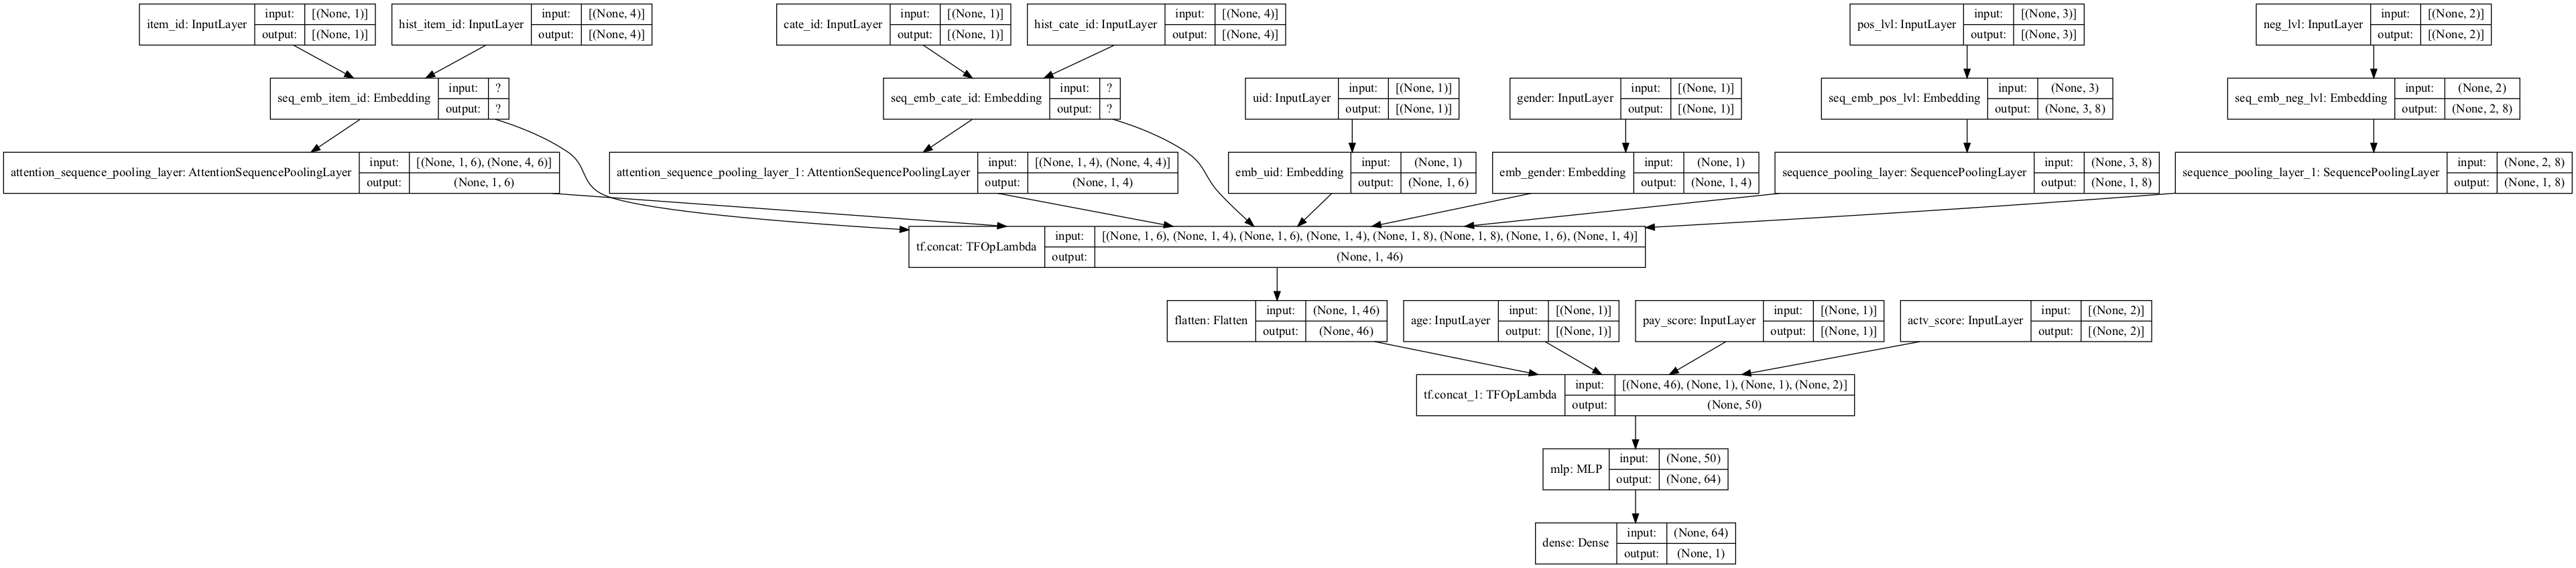

In [25]:
keras.utils.plot_model(model, "simple_din_model.png", show_shapes=True)

In [26]:
model.compile('adam', 'binary_crossentropy',
              metrics=['binary_crossentropy'])
model.fit(x, y, batch_size=100, epochs=1, validation_split=0.5)

2023-05-31 00:13:36.498100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


1/1 [==============================] - 2s 2s/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 3.1356 - val_binary_crossentropy: 3.1356
